## Vanilla LSTM model for EEG data

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import Conv2D, LSTM,BatchNormalization, MaxPooling2D, Reshape, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

2024-03-13 21:29:48.398348: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-13 21:29:48.398493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-13 21:29:48.659780: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
X_test = np.load("/kaggle/input/c147-project/X_test.npy")
y_test = np.load("/kaggle/input/c147-project/y_test.npy")
person_train_valid = np.load("/kaggle/input/c147-project/person_train_valid.npy")
X_train_valid = np.load("/kaggle/input/c147-project/X_train_valid.npy")
y_train_valid = np.load("/kaggle/input/c147-project/y_train_valid.npy")
person_test = np.load("/kaggle/input/c147-project/person_test.npy")

y_train_valid -= 769
y_test -= 769

In [ ]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [ ]:
#train function
def train_data_prep(X,y,sub_sample,average,noise):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,500) -> (sample,22,500/sub_sample) - downsampling; performing low pass filtering on EEG signals
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)


    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    #first: mean pooling - downsampling method; smoothing
    #second: add Gaussian noise; regularizing effect
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average)) #vertical stacking; 4230 samples after stacking; size of dataset increased; each of dimension 22x400
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)

    # Subsampling + noise addition

    for i in range(sub_sample):

        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))


    print('Shape of X after subsampling and concatenating:',total_X.shape)
    print('Shape of Y:',total_y.shape)
    return total_X,total_y

In [ ]:
def test_data_prep(X):

    total_X = None


    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,500) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 4), axis=3)


    total_X = X_max
    print('Shape of X after maxpooling:',total_X.shape)

    return total_X

## Data Preprocessing to prevent data leakage


In [ ]:
from sklearn.model_selection import train_test_split

## Random splitting and reshaping the data

# First generating the training and validation indices using random splitting
ind_valid = np.random.choice(2115, 250, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

X_train_prep,y_train_prep = train_data_prep(x_train,y_train,4,4,True)
X_val_prep,y_val_prep = train_data_prep(x_valid,y_valid,4,4,True)
print("Val prep shape=",X_val_prep.shape)
X_test_prep = test_data_prep(X_test)

Shape of training set: (1865, 22, 1000)
Shape of validation set: (250, 22, 1000)
Shape of training labels: (1865,)
Shape of validation labels: (250,)
Shape of X after trimming: (1865, 22, 500)
Shape of X after maxpooling: (1865, 22, 125)
Shape of X after averaging+noise and concatenating: (3730, 22, 125)
Shape of X after subsampling and concatenating: (11190, 22, 125)
Shape of Y: (11190,)
Shape of X after trimming: (250, 22, 500)
Shape of X after maxpooling: (250, 22, 125)
Shape of X after averaging+noise and concatenating: (500, 22, 125)
Shape of X after subsampling and concatenating: (1500, 22, 125)
Shape of Y: (1500,)
Val prep shape= (1500, 22, 125)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 125)


In [ ]:
print(X_val_prep.shape)

(1500, 22, 125)


In [ ]:
print('Shape of training set:',X_train_prep.shape)
print('Shape of validation set:',X_val_prep.shape)
print('Shape of training labels:',y_train_prep.shape)
print('Shape of validation labels:',y_val_prep.shape)

Shape of training set: (11190, 22, 125)
Shape of validation set: (1500, 22, 125)
Shape of training labels: (11190,)
Shape of validation labels: (1500,)


In [ ]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train_prep, 4)
y_val = to_categorical(y_val_prep, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_val.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

x_train = X_train_prep
x_valid = X_val_prep
x_test = X_test_prep

x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,2)

Shape of training labels after categorical conversion: (11190, 4)
Shape of validation labels after categorical conversion: (1500, 4)
Shape of test labels after categorical conversion: (443, 4)


In [ ]:
print(x_train.shape)

(11190, 125, 22)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Bidirectional

In [ ]:
#create lstm model
input_shape = (125, 22)
x_train_reshaped = x_train.reshape((11190, 125, 22))
model = Sequential()
model.add(BatchNormalization())
model.add(Bidirectional(LSTM(units=4, activation='tanh', input_shape=input_shape, return_sequences=True)))
model.add(Dropout(0.6))
model.add(Flatten())
model.add(Dense(units=4, activation='softmax'))
model.build(input_shape=(None, 125, 22))

#printing the model summary
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization             │ (None, 125, 22)        │            88 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 125, 8)         │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 125, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         4,004 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,956 (19.36 KB)

 Trainable params: 4,912 (19.19 KB)

 Non-trainable params: 44 (176.00 B)

In [ ]:
# Model parameters
learningrate = 1e-3
epochs = 50
model_optimizer = Adam(learning_rate=learningrate)

In [ ]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
                 optimizer=model_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
model_results = model.fit(x_train_reshaped,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_val), verbose=True)

Epoch 1/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.3469 - loss: 1.3654 - val_accuracy: 0.4833 - val_loss: 1.1720
Epoch 2/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5254 - loss: 1.1092 - val_accuracy: 0.5300 - val_loss: 1.0695
Epoch 3/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5828 - loss: 1.0185 - val_accuracy: 0.5567 - val_loss: 1.0186
Epoch 4/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6240 - loss: 0.9401 - val_accuracy: 0.5760 - val_loss: 0.9951
Epoch 5/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6314 - loss: 0.9141 - val_accuracy: 0.5893 - val_loss: 0.9703
Epoch 6/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6539 - loss: 0.8779 - val_accuracy: 0.5933 - val_loss: 0.9523
Epoch 7/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6705 - loss: 0.8367 - val_accuracy: 0.6040 - val_loss: 0.9306
Epoch 8/50
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6804 - loss: 0.8207 - val_accu

In [ ]:
## Testing the LSTM model

lstm_score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the LSTM model:',lstm_score[1])

Test accuracy of the LSTM model: 0.6365688443183899


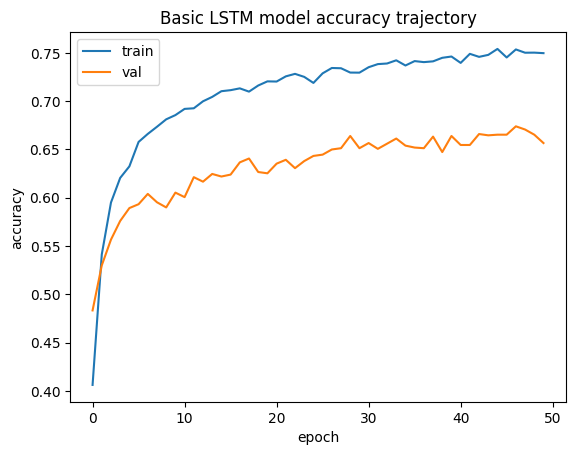

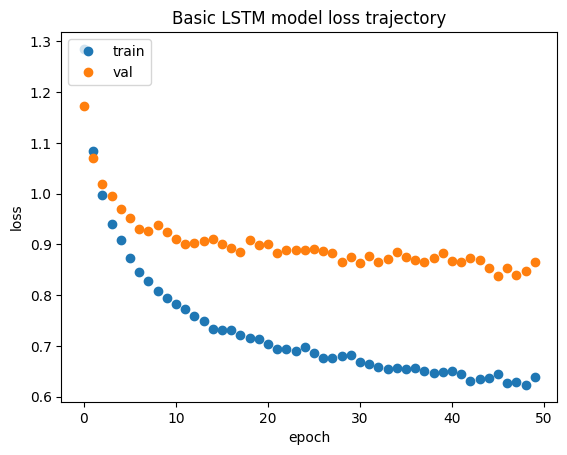

In [ ]:
import matplotlib.pyplot as plt

# Plotting accuracy trajectory
plt.plot(model_results.history['accuracy'])
plt.plot(model_results.history['val_accuracy'])
plt.title('Basic LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(model_results.history['loss'],'o')
plt.plot(model_results.history['val_loss'],'o')
plt.title('Basic LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()